<div class="alert alert-block alert-success" style="font-size:30px">
🦴 [inference] Pytorch EfficientNet-v2 single model LB:0.49; 5-fold ensemble LB:0.47 🦴
</div>

This is a bare-bones PyTorch implementation of EfficientNet-v2 based classifier. This is a simple baseline implementation that can be iteratively improved.

<img src="https://images2.imgbox.com/cd/58/AeY81v9Y_o.png" alt="image host"/>


Here is a high level explanation of the **inference** flow:
1. Images are loaded from test folder and transformed to `3x384x384` tensors using the same transformations used in training.
2. Images are passed to an ensemble of trained `EfficientNet_V2_S`-based multi-label classifiers. The classifier produces probabilities of fractures and probabilities of existence of certain vertebrae in each slice. Note that you can also use a single model `effnetv2` which is trained on all folds and likely performs slightly better than any of the fold-models.
3. We use a non-parametric model to combine predictions of base models:
    * For each StudyInstanceUID we first aggregate predictions for each of C1-C7 vertebrae by weighted averaging fracture predictions. Probabilities of vertebrae are used as weights. Example: if we are uncertain that C3 is in the slice (`C3_effnet_vert==0.1`), but we somehow predict high probability of C3 being fractured (`C3_effnet_frac==0.9`), we add it to the final aggregate with low weight `0.9 * 0.1 == 0.09`
    * We use a simple probability formula to derive `patient_overall` fracture probability. `patient_overall` is a probability of any vertebrae being fractured. It is equal to `1-no-vertebrae-are-fractured`. Under assumption of independence of vertebrae fractures we can derive the following simple equation: $P_{\text{patient_overall}}=1-\prod_i{[1-C_i]}$


<div class="alert alert-block alert-success" style="font-size:25px">
🦴 1. Imports, constants and dependencies 🦴
</div>

In [1]:
try:
    import pylibjpeg
except:
    # Offline dependencies:
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/

    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

Processing /kaggle/input/rsna-2022-whl/pydicom-2.3.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/rsna-2022-whl/torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl
Processing /kaggle/input/rsna-2022-whl/torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [2]:
import gc
import glob
import os
import re

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.model_selection import GroupKFold
from torch.cuda.amp import GradScaler, autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
plt.rcParams['figure.figsize'] = (20, 5)


# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT
RSNA_2022_PATH = '../input/rsna-2022-cervical-spine-fracture-detection'
TRAIN_IMAGES_PATH = f'{RSNA_2022_PATH}/train_images'
TEST_IMAGES_PATH = f'{RSNA_2022_PATH}/test_images'
EFFNET_CHECKPOINTS_PATH = '../input/rsna-2022-base-effnetv2'

# MODEL_NAMES = [f'effnetv2']

# This notebook supports ensembles and single model predictions. Uncomment to switch to ensemble prediction:
MODEL_NAMES = [f'effnetv2-f{i}' for i in range(5)]

# Common
FRAC_COLS = [f'C{i}_effnet_frac' for i in range(1, 8)]
VERT_COLS = [f'C{i}_effnet_vert' for i in range(1, 8)]

try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False


# Switch to offline for submission
os.environ["WANDB_MODE"] = "offline"

if os.environ["WANDB_MODE"] == "online":
    if IS_KAGGLE:
        os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")

if not IS_KAGGLE:
    print('Running locally')
    RSNA_2022_PATH = '/mnt/rsna2022'
    TRAIN_IMAGES_PATH = '/mnt/rsna2022/train_images'
    TEST_IMAGES_PATH = '/mnt/rsna2022/test_images'
    METADATA_PATH = '/home/vslaykovsky/Downloads/'
    EFFNET_CHECKPOINTS_PATH = 'frac_checkpoints'
    os.environ['WANDB_API_KEY'] = 'yourkeyhere'


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 2. Loading train/eval/test dataframes 🦴
</div>

1. Loading data from competition dataset folder `../input/rsna-2022-cervical-spine-fracture-detection/test.csv`
2. Joining data with slice information collected from test image folders `../input/rsna-2022-cervical-spine-fracture-detection/test_images/*/*`

In [3]:
def load_df_test():
    df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')

    if df_test.iloc[0].row_id == '1.2.826.0.1.3680043.10197_C1':
        # test_images and test.csv are inconsistent in the dev dataset, fixing labels for the dev run.
        df_test = pd.DataFrame({
            "row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
            "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
            "prediction_type": ["C1", "C1", "patient_overall"]}
        )
    return df_test

df_test = load_df_test()
df_test

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,patient_overall


In [4]:
test_slices = glob.glob(f'{TEST_IMAGES_PATH}/*/*')
test_slices = [re.findall(f'{TEST_IMAGES_PATH}/(.*)/(.*).dcm', s)[0] for s in test_slices]
df_test_slices = pd.DataFrame(data=test_slices, columns=['StudyInstanceUID', 'Slice']).astype({'Slice': int}).sort_values(['StudyInstanceUID', 'Slice']).reset_index(drop=True)
df_test_slices

,StudyInstanceUID,Slice
0,1.2.826.0.1.3680043.22327,1
1,1.2.826.0.1.3680043.22327,2
2,1.2.826.0.1.3680043.22327,3
3,1.2.826.0.1.3680043.22327,4
4,1.2.826.0.1.3680043.22327,5
...,...,...
1313,1.2.826.0.1.3680043.5876,454
1314,1.2.826.0.1.3680043.5876,455
1315,1.2.826.0.1.3680043.5876,456
1316,1.2.826.0.1.3680043.5876,457


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 3. Dataset class 🦴
</div>

`EffnetDataSet` class returns images of individual slices. It uses a dataframe parameter `df` as a source of slices metadata to locate and load images from `path` folder. It accepts transforms parameter which we set to `WEIGHTS.transforms()`. This is a set of transforms used to pre-train the model on ImageNet dataset.

Text(0.5, 1.0, 'jpeg')

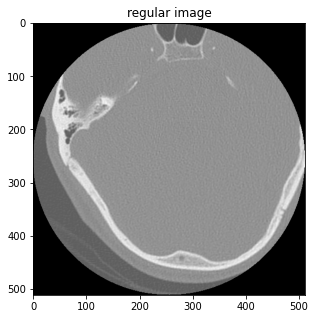

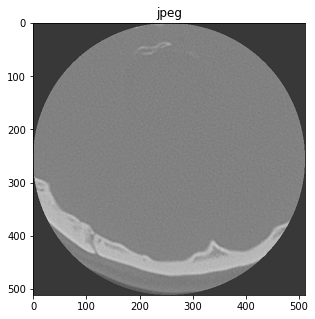

In [5]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array    
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10014/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [6]:
class EffnetDataSet(torch.utils.data.Dataset):    
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms
        
    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')        
        
        try:
            img = load_dicom(path)[0]         
            img = np.transpose(img, (2, 0, 1))  # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None
        
        if 'C1_fracture' in self.df:
            frac_targets = torch.as_tensor(self.df.iloc[i][['C1_fracture', 'C2_fracture', 'C3_fracture', 'C4_fracture', 'C5_fracture', 'C6_fracture', 'C7_fracture']].astype('float32').values)
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            frac_targets = frac_targets * vert_targets   # we only enable targets that are visible on the current slice
            return img, frac_targets, vert_targets
        return img        
    
    def __len__(self):
        return len(self.df)
    

In [7]:
# Only X values returned by the test dataset
ds_test = EffnetDataSet(df_test_slices, TEST_IMAGES_PATH, WEIGHTS.transforms())
X = ds_test[42]
X.shape

torch.Size([3, 384, 384])

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 4. Model 🦴
</div>


In Pytorch we use create_feature_extractor to access feature layers of pre-existing models. Final flat layer of `efficientnet_v2_s` model is called `flatten`. We'll build our classification layer on top of it. 

In [8]:
class EffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s()
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_fracture = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_fracture(x), self.nn_vertebrae(x)

    def predict(self, x):
        frac, vert = self.forward(x)
        return torch.sigmoid(frac), torch.sigmoid(vert)

model = EffnetModel()
model.predict(torch.randn(1, 3, 512, 512))
del model

In [9]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data)
    return model

In [10]:
effnet_models = [load_model(EffnetModel(), name, EFFNET_CHECKPOINTS_PATH).to(DEVICE) for name in MODEL_NAMES]

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 7. Submission 🦴
</div>

1. We run all baseline `effnet_model` on every image from the test set and average outputs 
2. We pass average outputs of the base `effnet_model` to the `lstm_model` to produce the final result for each patient.

In [11]:
from typing import List


def predict_effnet(models: List[EffnetModel], ds, max_batches=1e9):
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
    for m in models:
        m.eval()

    with torch.no_grad():
        predictions = []
        for idx, X in enumerate(tqdm(dl_test, miniters=10)):
            pred = torch.zeros(len(X), 14).to(DEVICE)
            for m in models:
                y1, y2 = m.predict(X.to(DEVICE))
                pred += torch.concat([y1, y2], dim=1) / len(models)
            predictions.append(pred)
            if idx >= max_batches:
                break
        return torch.concat(predictions).cpu().numpy()

# Quick test
predict_effnet([EffnetModel().to(DEVICE)], ds_test, max_batches=2).shape

  0%|          | 0/42 [00:00<?, ?it/s]

(96, 14)

In [12]:
effnet_pred = predict_effnet(effnet_models, ds_test)

df_effnet_pred = pd.DataFrame(
    data=effnet_pred, columns=[f'C{i}_effnet_frac' for i in range(1, 8)] + [f'C{i}_effnet_vert' for i in range(1, 8)]
)

  0%|          | 0/42 [00:00<?, ?it/s]

In [13]:
df_test_pred = pd.concat([df_test_slices, df_effnet_pred], axis=1).sort_values(['StudyInstanceUID', 'Slice'])
df_test_pred

,StudyInstanceUID,Slice,C1_effnet_frac,C2_effnet_frac,C3_effnet_frac,C4_effnet_frac,C5_effnet_frac,C6_effnet_frac,C7_effnet_frac,C1_effnet_vert,C2_effnet_vert,C3_effnet_vert,C4_effnet_vert,C5_effnet_vert,C6_effnet_vert,C7_effnet_vert
0,1.2.826.0.1.3680043.22327,1,0.000490,0.000366,0.000359,0.000258,0.000205,0.000231,0.000695,0.000454,0.000269,0.000283,0.000164,0.000051,0.000080,0.000327
1,1.2.826.0.1.3680043.22327,2,0.000548,0.000423,0.000430,0.000305,0.000232,0.000264,0.000920,0.000426,0.000242,0.000365,0.000184,0.000050,0.000091,0.000482
2,1.2.826.0.1.3680043.22327,3,0.000554,0.000492,0.000462,0.000315,0.000267,0.000332,0.001069,0.000342,0.000271,0.000407,0.000170,0.000056,0.000123,0.000543
3,1.2.826.0.1.3680043.22327,4,0.000503,0.000473,0.000483,0.000352,0.000311,0.000377,0.001008,0.000269,0.000249,0.000495,0.000228,0.000077,0.000157,0.000505
4,1.2.826.0.1.3680043.22327,5,0.000486,0.000488,0.000504,0.000365,0.000329,0.000404,0.000999,0.000264,0.000274,0.000559,0.000255,0.000087,0.000177,0.000494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,1.2.826.0.1.3680043.5876,454,0.000491,0.000411,0.000320,0.000317,0.000341,0.000311,0.000402,0.000692,0.000379,0.000427,0.000399,0.000347,0.000277,0.000184
1314,1.2.826.0.1.3680043.5876,455,0.000549,0.000455,0.000330,0.000315,0.000324,0.000289,0.000403,0.000903,0.000470,0.000463,0.000394,0.000339,0.000263,0.000204
1315,1.2.826.0.1.3680043.5876,456,0.000552,0.000488,0.000338,0.000316,0.000311,0.000279,0.000440,0.000758,0.000467,0.000472,0.000400,0.000294,0.000243,0.000234
1316,1.2.826.0.1.3680043.5876,457,0.000557,0.000429,0.000310,0.000305,0.000298,0.000267,0.000468,0.000732,0.000330,0.000346,0.000371,0.000256,0.000209,0.000245


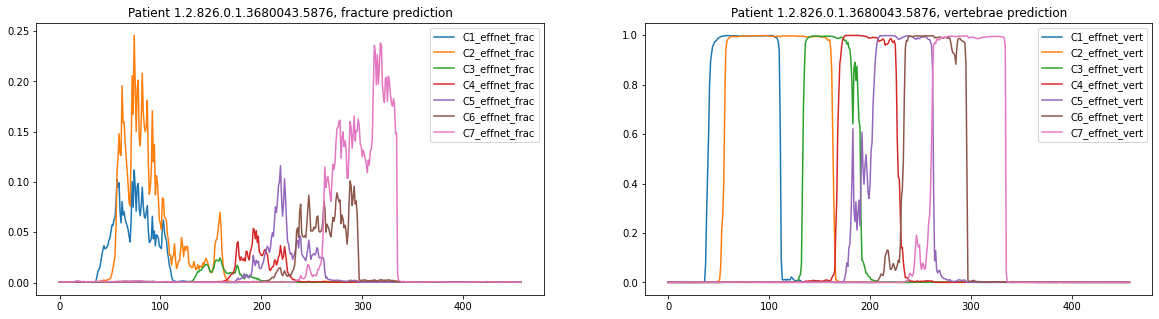

In [14]:
def plot_sample_patient(df_pred):
    patient = np.random.choice(df_pred.StudyInstanceUID)
    df = df_pred.query('StudyInstanceUID == @patient').reset_index()

    df[[f'C{i}_effnet_frac' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, fracture prediction',
        ax=(plt.subplot(1, 2, 1)))

    df[[f'C{i}_effnet_vert' for i in range(1, 8)]].plot(
        title=f'Patient {patient}, vertebrae prediction',
        ax=plt.subplot(1, 2, 2)
    )

plot_sample_patient(df_test_pred)

In [15]:

def patient_prediction(df):
    c1c7 = np.average(df[FRAC_COLS].values, axis=0, weights=df[VERT_COLS].values)
    pred_patient_overall = 1 - np.prod(1 - c1c7)
    return pd.Series(data=np.concatenate([[pred_patient_overall], c1c7]), index=['patient_overall'] + [f'C{i}' for i in range(1, 8)])

df_patient_pred = df_test_pred.groupby('StudyInstanceUID').apply(lambda df: patient_prediction(df))
df_patient_pred

,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.22327,0.494886,0.032177,0.064765,0.041566,0.079764,0.101204,0.112345,0.206940
1.2.826.0.1.3680043.25399,0.477033,0.073948,0.074153,0.063346,0.062717,0.073354,0.138978,0.129193
1.2.826.0.1.3680043.5876,0.349543,0.055733,0.073613,0.012201,0.025163,0.038483,0.060258,0.145396


In [16]:
df_sub = df_test.copy()
df_sub = df_sub.set_index('StudyInstanceUID').join(df_patient_pred)
df_sub['fractured'] = df_sub.apply(lambda r: r[r.prediction_type], axis=1)
df_sub

,row_id,prediction_type,patient_overall,C1,C2,C3,C4,C5,C6,C7,fractured
StudyInstanceUID,,,,,,,,,,,
1.2.826.0.1.3680043.22327,1.2.826.0.1.3680043.22327_C1,C1,0.494886,0.032177,0.064765,0.041566,0.079764,0.101204,0.112345,0.206940,0.032177
1.2.826.0.1.3680043.25399,1.2.826.0.1.3680043.25399_C1,C1,0.477033,0.073948,0.074153,0.063346,0.062717,0.073354,0.138978,0.129193,0.073948
1.2.826.0.1.3680043.5876,1.2.826.0.1.3680043.5876_C1,patient_overall,0.349543,0.055733,0.073613,0.012201,0.025163,0.038483,0.060258,0.145396,0.349543


In [17]:
df_sub['fractured'] = df_sub['fractured'].apply(lambda x: 0.95 if x >= 0.95 else x) 
df_sub['fractured'] = df_sub['fractured'].apply(lambda x: 0.05 if x <= 0.05 else x) 

In [18]:
df_sub[['row_id', 'fractured']].to_csv('submission.csv', index=False)